In [1]:
%load_ext sql
%sql mysql+pymysql://root@localhost/myemployees

'Connected: root@myemployees'

# mysql逻辑架构

mysql采用分层架构，不同层做不同事情，出现问题就找相应的层，这种思想也经常用在个人项目开发中。

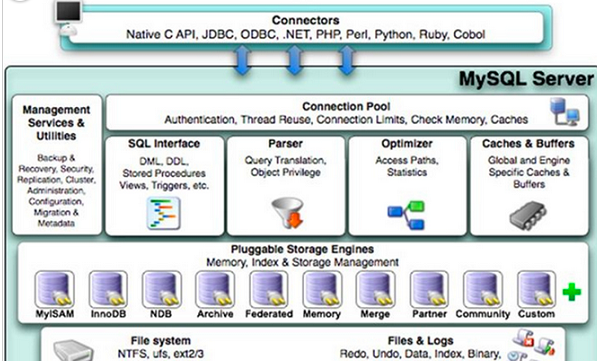

1.  连接层

最上层是一些客户端和连接服务，包含本地sock通信和大多数基于客户端/服务端工具实现的类似于tcp/ip的通信。主要完成一些类似于连接处理、授权认证、及相关的安全方案。在该层上引入了线程池的概念，为通过认证安全接入的客户端提供线程。同样在该层上可以实现基于SSL的安全链接。服务器也会为安全接入的每个客户端验证它所具有的操作权限。



2. 服务层



简而言之，服务层主要是用来做sql的解析，优化，最后生成相应的执行操作。
3. 引擎层

存储引擎层，存储引擎真正的负责了MySQL中数据的存储和提取，服务器通过API与存储引擎进行通信。不同的存储引擎具有的功能不同，这样我们可以根据自己的实际需要进行选取。

4. 存储层

数据存储层，主要是将数据存储在运行于裸设备的文件系统之上，并完成与存储引擎的交互。

# mysql大致查询流程

1. mysql客户端通过协议与mysql服务器建连接，发送查询语句，先检查查询缓存，如果命中，直接返回结果，否则进行语句解析,也就是说，在解析查询之前，服务器会先访问查询缓存(query cache)——它存储SELECT语句以及相应的查询结果集。如果某个查询结果已经位于缓存中，服务器就不会再对查询进行解析、优化、以及执行。它仅仅将缓存中的结果返回给用户即可，这将大大提高系统的性能。

2. 语法解析器和预处理：首先mysql通过关键字将SQL语句进行解析，并生成一颗对应的“解析树”。mysql解析器将使用mysql语法规则验证和解析查询；预处理器则根据一些mysql规则进一步检查解析数是否合法。

3. 查询优化：查询优化器当解析树被认为是合法的了，并且由优化器将其转化成执行计划。一条查询可以有很多种执行方式，最后都返回相同的结果。优化器的作用就是找到这其中最好的执行计划。。

4. 然后，mysql默认使用的BTREE索引，并且一个大致方向是:无论怎么折腾sql，至少在目前来说，mysql最多只用到表中的一个索引。

## sql语句解析顺序

```
SELECT
FROM <left_table>
<join_type> JOIN <right_table>
ON <JOIN_condition>
WHERE <where_condtion>
GROUP BY <group_by_list>
HAVING <having_condition>
ORDER BY <order_by_condition>
LIMIT <limit_number>
```


1. from 
2. join 
3. on 
4. where 
5. group by(开始使用select中的别名，后面的语句中都可以使用)
6. avg,sum.... 
7. having 
8. select 
9. distinct 
10. order by 
11. limit 


从这个顺序中我们不难发现，所有的查询语句都是从from开始执行的，在执行过程中，每个步骤都会为下一个步骤生成一个虚拟表，这个虚拟表将作为下一个执行步骤的输入。 
1. 首先对from子句中的前两个表执行一个笛卡尔乘积，此时生成虚拟表 vt1（选择相对小的表做基础表） 
2. 接下来便是应用on筛选器，on 中的逻辑表达式将应用到 vt1 中的各个行，筛选出满足on逻辑表达式的行，生成虚拟表 vt2 
3. 如果是outer join <font color="red">那么这一步就将添加外部行，</font>left outer jion 就把左表在第二步中过滤的添加进来，如果是right outer join 那么就将右表在第二步中过滤掉的行添加进来，这样生成虚拟表 vt3 
4. 如果 from 子句中的表数目多余两个表，那么就将vt3和第三个表连接从而计算笛卡尔乘积，生成虚拟表，该过程就是一个重复1-3的步骤，最终得到一个新的虚拟表 vt3。 
5. 应用where筛选器，对上一步生产的虚拟表引用where筛选器，生成虚拟表vt4
6. group by 子句将中的唯一的值组合成为一组，得到虚拟表vt5。如果应用了group by，那么后面的所有步骤都只能得到的vt5的列或者是聚合函数（count、sum、avg等）。原因在于最终的结果集中只为每个组包含一行。
7. 应用having筛选器，生成vt6。having筛选器是第一个也是<font color="red">唯一一个应用到已分组数据的筛选器。</font> 
8. 处理select子句。将vt6中的在select中出现的列筛选出来。生成vt7. 
9. 应用distinct子句，vt7中移除相同的行，生成vt8。事实上如果应用了group by子句那么distinct是多余的，原因同样在于，分组的时候是将列中唯一的值分成一组，同时只为每一组返回一行记录，那么所以的记录都将是不相同的。 
10. 应用order by子句。按照order_by_condition排序vt8，此时返回的一个游标，而不是虚拟表。sql是基于集合的理论的，集合不会预先对他的行排序，它只是成员的逻辑集合，成员的顺序是无关紧要的。对表进行排序的查询可以返回一个对象，这个对象包含特定的物理顺序的逻辑组织。这个对象就叫游标。正因为返回值是游标，那么使用order by后面不能接表达式。排序是很需要成本的，除非你必须要排序，否则最好不要指定order by，最后，在这一步中是<font color="red">第一个也是唯一一个可以使用select列表中别名的步骤。</font>
11. 应用limit选项。此时才返回结果给请求者即用户。 

# MyISAM和InnoDB

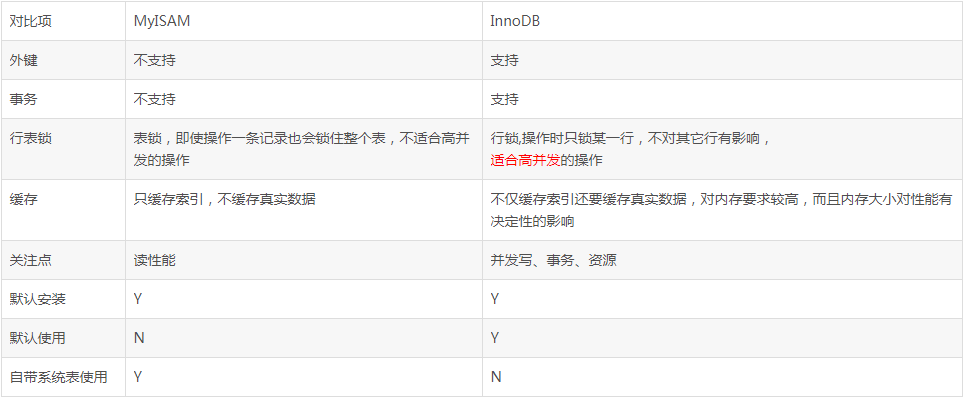

面试回答：myisam不支持外键、事务，只有表锁，innodb支持外键、事务，既有行锁也有表锁。

In [3]:
# 查看所有数据库存储引擎
%sql show engines;

 * mysql+pymysql://root@localhost/myemployees
9 rows affected.


[('ARCHIVE', 'YES', 'Archive storage engine', 'NO', 'NO', 'NO'),
 ('BLACKHOLE', 'YES', '/dev/null storage engine (anything you write to it disappears)', 'NO', 'NO', 'NO'),
 ('MRG_MYISAM', 'YES', 'Collection of identical MyISAM tables', 'NO', 'NO', 'NO'),
 ('FEDERATED', 'NO', 'Federated MySQL storage engine', None, None, None),
 ('MyISAM', 'YES', 'MyISAM storage engine', 'NO', 'NO', 'NO'),
 ('PERFORMANCE_SCHEMA', 'YES', 'Performance Schema', 'NO', 'NO', 'NO'),
 ('InnoDB', 'DEFAULT', 'Supports transactions, row-level locking, and foreign keys', 'YES', 'YES', 'YES'),
 ('MEMORY', 'YES', 'Hash based, stored in memory, useful for temporary tables', 'NO', 'NO', 'NO'),
 ('CSV', 'YES', 'CSV storage engine', 'NO', 'NO', 'NO')]

In [4]:
# 查看默认的数据库引擎
%sql show variables like "%storage_engine%";

 * mysql+pymysql://root@localhost/myemployees
5 rows affected.


[('default_storage_engine', 'InnoDB'),
 ('default_tmp_storage_engine', 'InnoDB'),
 ('disabled_storage_engines', ''),
 ('internal_tmp_disk_storage_engine', 'InnoDB'),
 ('internal_tmp_mem_storage_engine', 'TempTable')]

# 索引优化

索引优化的目的是为了查询语句的优化，而不是增删改的优化。

## 索引的创建、删除和查看

* 创建: create index idx_user_name on user(name); 或者 alter table user add primary key (id);
* 删除：drop index idx_user_name on user;
* 查看：show index from user;

## 适合建索引和不适合建索引的情况


适合建立索引的情况：
1. 主键自动建立唯索引
2. 频繁作为查询条件的字段应该创建索引
3. 查询中与其它表关联的字段。外键关系建立索引
4. 查询中排序的字段，排序字段若通过索引去访问将大大提高排序速度
5. 查询中统计或者分组字段

不适合建索引:
1. 频繁更新的字段不适合创建索引:因为每次更新不单单是更新了记录还会更新索引
2. Where 条件里用不到的字段不创建索引
3. 单键/组合索引的选择问题，在高并发下倾向创建组合索引, 因为实际业务中查询条件是多个的居多
4. 某个数据列包含很多重复内容不适合创建索引

**索引的选择性:索引列中不同值的数目与表中记录数的比，值越接近1，这个索引的效率越高** 

## explain

explain可以帮助开发人员分析SQL问题，explain显示了mysql这个软件如何使用索引来处理select语句以及连接表，可以帮助选择更好的索引和写出更优化的查询语句。

使用方法：在select语句前加上explain就可以了(只是看一下mysql对这条select的执行计划，并非真正去执行这条select语句)。


In [6]:
%sql explain select * from account;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`account`.`name` AS `name`,`myemployees`.`account`.`balance` AS `balance` from `myemployees`.`account`')
  result = self._query(query)


[(1, 'SIMPLE', 'account', None, 'ALL', None, None, None, None, 4, 100.0, None)]

expain出来的信息有10列，分别是id、select_type、table、type、possible_keys、key、key_len、ref、rows、Extra,下面对这些字段出现的可能进行解释

### id

id用来表示一条select语句中表的加载顺序。

1. id相同时, 执行顺序由上至下
2. 如果是子查询, id的序号会递增,id值越大优先级越高, 越先被执行
3. id如果相同, 可以认为是一组, 从上往下顺序执行; 在所有组中, id值越大, 优先级越高,越先执行.



In [7]:
%sql explain select * from account,admin;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`account`.`name` AS `name`,`myemployees`.`account`.`balance` AS `balance`,`myemployees`.`admin`.`username` AS `username`,`myemployees`.`admin`.`password` AS `password` from `myemployees`.`account` join `myemployees`.`admin`')
  result = self._query(query)


[(1, 'SIMPLE', 'account', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'admin', None, 'ALL', None, None, None, None, 5, 100.0, 'Using join buffer (Block Nested Loop)')]

id相同，都是1，执行顺序是从上到下，也就是先加载account表，再加载admin.

### table

显示这一行的数据是关于哪张表的，有时不是真实的表名字,看到的是derivedx(x是个数字,我的理解是第几步执行的结果).

### select_type

表示查询中每个select子句的类型，主要是用于区别查询是普通查询、联合查询还是子查询。

比较常见的是以下几种：
* SIMPLE: 简单select（不使用union或子查询）
* PRIMARY: 查询中若包含任何复杂的子部分,最外层的select被标记为PRIMARY
* SUBQUERY: 在select或where列表中包含的子查询
* DERIVED: FROM子句的子查询
* UNION: union中的第二个或后面的select语句。若 UNION 包含在 FROM 子句的子查询中，外层 SELECT 将被标记为：DERIVED
* UNION RESULTI: UNION的结果


In [9]:
%sql CREATE TABLE if not exists dept (\
id int(11) PRIMARY KEY auto_increment, deptName VARCHAR(30), locAdd VARCHAR(40) \
);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1050, "Table 'dept' already exists")
  result = self._query(query)


[]

In [10]:
%sql CREATE TABLE if not exists emp ( \
id INT (11) PRIMARY KEY AUTO_INCREMENT, name VARCHAR(20), deptld INT(11), \
CONSTRAINT fk_dept_id FOREIGN KEY(deptld) REFERENCES dept(id));

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1050, "Table 'emp' already exists")
  result = self._query(query)


[]

In [14]:
%sql insert into dept (deptName, locAdd) VALUES ('RD',"11"), ('HR',"12"), ('MK',"13"), ('MIS',"14"), ('FD',"15"); 


 * mysql+pymysql://root@localhost/myemployees
5 rows affected.


[]

In [20]:
%sql insert into emp(name, deptld) values ("jack", 1), ("tom", 2), ("lily", 3), ("egg", 1);

 * mysql+pymysql://root@localhost/myemployees
4 rows affected.


[]

In [25]:
%sql select * from dept;


 * mysql+pymysql://root@localhost/myemployees
10 rows affected.


[(1, 'RD', '11'),
 (2, 'HR', '12'),
 (3, 'MK', '13'),
 (4, 'MIS', '14'),
 (5, 'FD', '15'),
 (6, 'RD', '11'),
 (7, 'HR', '12'),
 (8, 'MK', '13'),
 (9, 'MIS', '14'),
 (10, 'FD', '15')]

In [24]:
%sql select * from emp;

 * mysql+pymysql://root@localhost/myemployees
4 rows affected.


[(16, 'jack', 1), (17, 'tom', 2), (18, 'lily', 3), (19, 'egg', 1)]

In [26]:
%sql explain \
select * from emp a left join dept b on a.deptld = b.id \
union \
select * from emp a right join dept b on a.deptld = b.id

 * mysql+pymysql://root@localhost/myemployees
5 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`a`.`id` AS `id`,`myemployees`.`a`.`name` AS `name`,`myemployees`.`a`.`deptld` AS `deptld`,`myemployees`.`b`.`id` AS `id`,`myemployees`.`b`.`deptName` AS `deptName`,`myemployees`.`b`.`locAdd` AS `locAdd` from `myemployees`.`emp` `a` left join `myemployees`.`dept` `b` on((`myemployees`.`b`.`id` = `myemployees`.`a`.`deptld`)) where 1 union /* select#2 */ select `myemployees`.`a`.`id` AS `id`,`myemployees`.`a`.`name` AS `name`,`myemployees`.`a`.`deptld` AS `deptld`,`myemployees`.`b`.`id` AS `id`,`myemployees`.`b`.`deptName` AS `deptName`,`myemployees`.`b`.`locAdd` AS `locAdd` from `myemployees`.`dept` `b` left join `myemployees`.`emp` `a` on((`myemployees`.`a`.`deptld` = `myemployees`.`b`.`id`)) where 1')
  result = self._query(query)


[(1, 'PRIMARY', 'a', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'PRIMARY', 'b', None, 'eq_ref', 'PRIMARY', 'PRIMARY', '4', 'myemployees.a.deptld', 1, 100.0, None),
 (2, 'UNION', 'b', None, 'ALL', None, None, None, None, 10, 100.0, None),
 (2, 'UNION', 'a', None, 'ALL', 'fk_dept_id', None, None, None, 4, 100.0, 'Using where; Using join buffer (Block Nested Loop)'),
 (None, 'UNION RESULT', '<union1,2>', None, 'ALL', None, None, None, None, None, None, 'Using temporary')]

### type

表示MySQL在表中找到所需行的方式，又称"访问类型"。

常用的类型有： ALL, index,  range, ref, eq_ref, const, system（从左到右，性能从差到好）, 也就是system>const>eq_ref>ref>range>index>ALL。

* ALL：Full Table Scan， MySQL将遍历全表以找到匹配的行
* index: Full Index Scan，index与ALL区别为index类型只遍历索引树(非主键索引不挂数据，可以扫描索引树得到记录指针)
* range: 只检索给定范围的行，使用一个索引来选择行。key 列显示使用了哪个索引。一般就是在 where 语句中出现了 between  <> in 等的查询
  这种范围扫描比全表扫描要好。因为它只需要开始于索引的某一点，而结束于另一点，不用扫描全部索引。
* ref: 表示上述表的连接匹配条件，即哪些列或常量被用于查找索引列上的值。说的更直白一点，是非唯一性索引扫描。返回匹配某个单独值的所有行。
  本质上也是一种索引访问。它返回所有匹配某个单整值的行。然而，它可能找到多个符合条件的行，所以应该属于查找和扫描的混合体。
* eq_ref: 类似ref，区别就在使用的索引是唯一索引，对于每个索引键值，表中只有一条记录匹配(扫描扫到一条记录就不再继续扫描了)，简单来说，就是多表连接中使用primary key或者 unique key作为关联条件
* const: 当MySQL对查询某部分进行优化，并转换为一个常量时，使用这些类型访问。表示通过索引一次就找到了(找到一行记录mysql就不继续往下找了), const 用于比较 primary key 或者 unique 索引。因为只匹配一行数据，所以很快。如将主键置于where列表中，MySQL就能将该查询转换为一个常量.
* system是: const类型的特例，当查询的表只有一行的情况下，使用system

In [27]:
%sql explain select * from dept where id=1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select '1' AS `id`,'RD' AS `deptName`,'11' AS `locAdd` from `myemployees`.`dept` where 1")
  result = self._query(query)


[(1, 'SIMPLE', 'dept', None, 'const', 'PRIMARY', 'PRIMARY', '4', 'const', 1, 100.0, None)]

对主键或唯一键的查找，一般找固定的常数次就能找到数据，且第一次找到就可以返回不需要继续往下找了。

In [28]:
%sql explain select * from emp left join dept on emp.deptld = dept.id;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`id` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'eq_ref', 'PRIMARY', 'PRIMARY', '4', 'myemployees.emp.deptld', 1, 100.0, None)]

使用left join, 左表emp需要全部扫描，拿着emp的记录去dept去匹配行，因为对于emp的每一个deptld，dept只能有一个记录满足，所以是eq_ref.

In [29]:
%sql explain select * from emp where deptld=1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld` from `myemployees`.`emp` where (`myemployees`.`emp`.`deptld` = 1)')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ref', 'fk_dept_id', 'fk_dept_id', '5', 'const', 2, 100.0, None)]

对于emp的deptld=1这样的记录会有多条，非唯一性索引扫描，所以是ref

In [31]:
%sql explain select * from emp where deptld in (1,2,3);

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld` from `myemployees`.`emp` where (`myemployees`.`emp`.`deptld` in (1,2,3))')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'range', 'fk_dept_id', 'fk_dept_id', '5', None, 4, 100.0, 'Using index condition')]

In [34]:
%sql explain select id from emp;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id` from `myemployees`.`emp`')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'index', None, 'fk_dept_id', '5', None, 4, 100.0, 'Using index')]

只需要查询id，不需要扫描data部分，所以在表中找到所需行的方式是index.

### possible_keys

指出MySQL能使用哪个索引在表中找到记录，查询涉及到的字段上若存在索引，则该索引将被直接列出，但不一定被查询使用。也就是说，mysql第一步先随意看一下，哪些索引可能会被这条语句使用就一股脑先列在这边，在第二步真实去使用索引的时候这些索引不一定是能被用上的。

如果该列是NULL，则没有相关的索引。在这种情况下，可以通过检查WHERE子句看是否它引用某些列或适合索引的列来去建立索引提高查询性能。如果是这样，创造一个适当的索引并且再次用EXPLAIN检查查询

### Key

key列显示MySQL实际决定使用的键（索引）。如果为NULL，则没有使用到任何索引。查询中如果使用**覆盖索引**，则该索引只出现在key列表中。

**覆盖索引:select 后面接的字段和创建的复合索引的个数和顺序一模一样。**

In [35]:
%sql explain select deptld from emp;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`deptld` AS `deptld` from `myemployees`.`emp`')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'index', None, 'fk_dept_id', '5', None, 4, 100.0, 'Using index')]

### key_len

表示索引中使用的字节数，可通过该列计算查询中使用的索引的长度（key_len显示的值为索引字段的最大可能长度，并非实际使用长度，即key_len是根据表定义计算而得，不是通过表内检索出的）, 不损失精确性的情况下，长度越短越好. 对于key_len大致知道就好。

### ref

显示索引的哪一列被使用了，如果可能的话，是一个常数。哪些列或者常量被用于查找索引列上的值。

In [36]:
%sql explain select * from emp left join dept on emp.deptld = dept.id;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`id` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'eq_ref', 'PRIMARY', 'PRIMARY', '4', 'myemployees.emp.deptld', 1, 100.0, None)]

上述例子可以看到，对于dept的id这一列，myemployees库的emp表的deptld这一列被用于查找索引列id上的值。

### rows

表示MySQL根据表统计信息及索引选用情况，估算的找到所需的记录所需要读取的行数，并非指硬盘IO的次数。

In [38]:
%sql explain select * from emp left join dept on emp.deptld = dept.id;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`id` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'eq_ref', 'PRIMARY', 'PRIMARY', '4', 'myemployees.emp.deptld', 1, 100.0, None)]

### Extra

该列包含MySQL解决查询的详细信息,有以下几种情况：
* Using temporary：表示MySQL需要使用临时表来存储结果集，<font color="red">常见于排序和分组查询。</font> 这种情况说明sql需要优化
* Using filesort：MySQL中<font color="red">无法利用索引完成的排序操作</font>称为"文件排序". 这种情况说明sql需要优化。
* Using index: 表示相应的 select 操作中使用了覆盖索引（Coverine Index），避免访问了表的数据行，效率不错！如果同时出现 using where，表明索引被用来执行索引键值的查找(也就是说索引被用来查询data数据)；如果没有出现using where，表明索引即数据而非用来执行查找动作。
* Using where: 在查找使用索引的情况下，需要回表去查询所需的数据
* Using index condition：查找使用了索引，但是需要回表查询数据。和using where的区别是using where一般和using index的结合效果才等于Using index condition.
* Using join buffer：使用了连接缓冲。explain执行计划中，type为all或者index或者range的时候，才会出现Using join buffer
* Impossible where：这个值强调了where语句会导致没有符合条件的行, 比如select * from account where 1=2;

日常的开发中，如果出现Using temporary和Using filesort一般需要调整索引进行优化了。

## 索引优化案例


### 单表查询优化

In [39]:
%sql CREATE TABLE IF NOT EXISTS article( \
id INT PRIMARY KEY AUTO_INCREMENT, author_id INT, \
category_id INT, views INT, comments INT, title VARBINARY (255), content TEXT);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1050, "Table 'article' already exists")
  result = self._query(query)


[]

In [40]:
%sql INSERT INTO article (author_id, category_id, views, comments, title, content) VALUES  (1, 1, 1,1, 4, 1), (2, 2, 2, 2, 2, 2), (1,1,3,3,3, 3);

 * mysql+pymysql://root@localhost/myemployees
3 rows affected.


[]

In [45]:
# 查询 category_id 为 1 且 comments 大于 1 的情况下 views 最多的author_id.
%sql select author_id from article where category_id = 1 and comments > 1 order by views DESC limit 1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


[(1,)]

In [47]:
%sql explain select author_id from article where category_id = 1 and comments > 1 order by views DESC limit 1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`article`.`author_id` AS `author_id` from `myemployees`.`article` where ((`myemployees`.`article`.`category_id` = 1) and (`myemployees`.`article`.`comments` > 1)) order by `myemployees`.`article`.`views` desc limit 1')
  result = self._query(query)


[(1, 'SIMPLE', 'article', None, 'ALL', None, None, None, None, 3, 33.33, 'Using where; Using filesort')]

首先看extra, 发现using filesort, 所以需要优化。再看type是ALL，查询数据使用的是全表扫描，这一点需要优化。

于是创建索引，最基本思路，where后面的涉及字段全加上索引：create index idx_article_ccv on article(category_id,comments,views) 

In [48]:
%sql create index idx_article_ccv on article(category_id,comments,views);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [49]:
%sql explain select author_id from article where category_id = 1 and comments > 1 order by views DESC limit 1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`article`.`author_id` AS `author_id` from `myemployees`.`article` where ((`myemployees`.`article`.`category_id` = 1) and (`myemployees`.`article`.`comments` > 1)) order by `myemployees`.`article`.`views` desc limit 1')
  result = self._query(query)


[(1, 'SIMPLE', 'article', None, 'range', 'idx_article_ccv', 'idx_article_ccv', '10', None, 1, 100.0, 'Using index condition; Using filesort')]

发现type从ALL变成range了，这是一个提升，但是Using filesort还在，这是因为范围会导致索引失效，也就是说 comments>1 这个会导致索引失效。简单考虑如下的三个组合索引：

|1|	1	|1|1|
|---|---|---|---|
|A|	A|B|C|
|1990|1991|1990|1881|

发现当第二个索引(这里是第二行)取大于A的时候，发现B和C这两列的1990和1881不是有序的，只有在同样都是B或者同样都是C的情况下时间才是有序的。同理，这里的comments>1会使得views无序。

解决办法:既然comments字段是一个范围，因此加索引的时候不加上这个字段即可。

In [50]:
%sql drop index idx_article_ccv on article;

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [51]:
%sql create index idx_article_cv on article(category_id,views);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [52]:
%sql explain select author_id from article where category_id = 1 and comments > 1 order by views DESC limit 1;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`article`.`author_id` AS `author_id` from `myemployees`.`article` where ((`myemployees`.`article`.`category_id` = 1) and (`myemployees`.`article`.`comments` > 1)) order by `myemployees`.`article`.`views` desc limit 1')
  result = self._query(query)


[(1, 'SIMPLE', 'article', None, 'ref', 'idx_article_cv', 'idx_article_cv', '5', 'const', 2, 33.33, 'Using where; Backward index scan')]

type从range变成ref，rows从1变成2(去除comments索引的缘故)，extra不再有using filesort了。因为利用上了category_id和views的复合索引结构。

备注：Backward index scan 是mysql8的新特性，暂时先不研究。


### 两表查询优化


In [54]:
# drop index fk_dept_id on emp; 删除外键不能使用普通的删除索引的方式, 需要先解除约束才能使用drop index
# 先解除外键的约束
%sql alter table emp drop foreign key fk_dept_id;

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [55]:
# 删除外键的索引键
%sql drop index fk_dept_id on emp;

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [56]:
%sql explain select * from emp left join dept on emp.deptld = dept.id;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`id` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'eq_ref', 'PRIMARY', 'PRIMARY', '4', 'myemployees.emp.deptld', 1, 100.0, None)]

In [57]:
# emp的deptld和dept的locAdd都没有建立索引:
%sql explain select * from emp left join dept on emp.deptld = dept.locAdd;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`locAdd` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'ALL', None, None, None, None, 10, 100.0, 'Using where; Using join buffer (Block Nested Loop)')]

type都是ALL, 肯定是需要建立索引去优化的。因为join类型是left, 所以左表是不可避免地一定会全部扫描,所以考虑在右表建立索引。


In [58]:
%sql create index idx_dept_l on dept(locAdd);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [59]:
%sql explain select * from emp left join dept on emp.deptld = dept.locAdd;

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, '/* select#1 */ select `myemployees`.`emp`.`id` AS `id`,`myemployees`.`emp`.`name` AS `name`,`myemployees`.`emp`.`deptld` AS `deptld`,`myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`emp` left join `myemployees`.`dept` on((`myemployees`.`dept`.`locAdd` = `myemployees`.`emp`.`deptld`)) where 1')
  result = self._query(query)


[(1, 'SIMPLE', 'emp', None, 'ALL', None, None, None, None, 4, 100.0, None),
 (1, 'SIMPLE', 'dept', None, 'ref', 'idx_dept_l', 'idx_dept_l', '5', 'myemployees.emp.deptld', 2, 100.0, None)]

发现dept的type变成ref了，另外rows也缩小了。

### 索引优化建议


1. 最好按照索引进行全值匹配
2. 复合索引的最左匹配认则。
3. 不在索引列上做任何操作（计算、函数。（自动 or 手动）类型转换）
4. 存储引擎不能使用索引中范围条件右边的列，也就是说索引遇到 > < 这些范围查询select语句右边的列就用不上索引
5. 尽量使用覆盖索引，减少 select * 
6. Mysql 在使用不等于的时候无法使用索引会导致全表扫描 
7. Is null, s not null 也无法使用索引
8. Like 以通配符开头("%aaa...") 索引失效会变成全表扫描
9. 字符串不加单引号索引失效(例如age是字符串的11,查询使用age=11, 虽然mysql会在内部做隐式转换查询到结果但是索引会用不上)
10. 少用or，用它来连接时索引会失效
11. 尽可能减少 Join 语句中的 NestedLoop 的循环总次数："永远用小结果集驱动大的结果集"(比如A表4条记录，B表1000条记录，如果B放在外层循环，A在内层，那么B表驱动A表，即使A表在相应字段加索引，还是需要1000次查询才能查到结果。相反，如果用A表作为驱动表，那么内层循环可能比之前的更"重", 但是因为可以加索引，所以能很快查到数据，所以也没重多少，这样只需要4次就能查到结果)。优先优化 NestedLoop 的内层循环：保证 Join 语句中被驱动表上 Join 条件字段已经被索引, 当无法保证被驱动表的 Join 条件字段被索引且内存资源充足的前提下，不要太吝 joinBuffer 的设置。

In [60]:
%sql create index idx_dept_d on dept(deptName);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [61]:
# 既然 like 以通配符开头("%aaa...") 索引失效会变成全表扫描, 那么如果业务需求就一定需要用到%在前怎办？可以利用覆盖索引，把全表扫描变成全索引扫描
%sql explain select * from dept where deptName like '%R';

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`dept`.`id` AS `id`,`myemployees`.`dept`.`deptName` AS `deptName`,`myemployees`.`dept`.`locAdd` AS `locAdd` from `myemployees`.`dept` where (`myemployees`.`dept`.`deptName` like '%R')")
  result = self._query(query)


[(1, 'SIMPLE', 'dept', None, 'ALL', None, None, None, None, 10, 11.11, 'Using where')]

In [62]:
%sql explain select deptName from dept where deptName like '%R';

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`dept`.`deptName` AS `deptName` from `myemployees`.`dept` where (`myemployees`.`dept`.`deptName` like '%R')")
  result = self._query(query)


[(1, 'SIMPLE', 'dept', None, 'index', None, 'idx_dept_d', '63', None, 10, 11.11, 'Using where; Using index')]

### mysql根据索引创建情况自动调整where条件的顺序

In [64]:
%sql create table test ( \
id int primary key auto_increment, \
c1 char(10), \
c2 char(10), \
c3 char(10), \
c4 char(10), \
c5 char(10) \
);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [65]:
%sql insert into test (c1, c2, c3, c4, c5) values ("a1", "a2", "a3", "a4", "a5"), ("b1", "b2", "b3", "b4", "b5"); 

 * mysql+pymysql://root@localhost/myemployees
2 rows affected.


[]

In [66]:
# 创建复合索引
%sql create index idx_test_c1234 on test(c1, c2, c3, c4);

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

In [69]:
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c2 = 'a2' and c3 = 'a3' and c4 ='a4';

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c4` = 'a4') and (`myemployees`.`test`.`c3` = 'a3') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c1` = 'a1'))")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '84', 'const,const,const,const', 1, 100.0, None)]

In [68]:
%sql EXPLAIN SELECT * FROM test WHERE c4 = 'a4' and c3 ='a3' and c2 = 'a2' and c1 = 'a1' ;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c1` = 'a1') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c3` = 'a3') and (`myemployees`.`test`.`c4` = 'a4'))")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '84', 'const,const,const,const', 1, 100.0, None)]

发现where的条件c1, c2, c3, c4的条件顺序变化，explain得到的执行计划是相同的，这是因为mysql根据建立的复合索引的顺序内部进行了顺序的调整从而用上了索引。

In [70]:
# c1和c2用上了索 引，从c3开始就是range了，c4就没法用索引了
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c2 = 'a2' and c3>'a3' and c4='a4'

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c4` = 'a4') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c1` = 'a1') and (`myemployees`.`test`.`c3` > 'a3'))")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'range', 'idx_test_c1234', 'idx_test_c1234', '63', None, 1, 50.0, 'Using index condition')]

In [71]:
# mysql自己会调整顺序，c1,c2,c3,c4都用到了索引，c4被调整到了最后,key_len说明c4被调整了到了最后面。
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c2 = 'a2'and c4>'a4' and c3='a3'

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c3` = 'a3') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c1` = 'a1') and (`myemployees`.`test`.`c4` > 'a4'))")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'range', 'idx_test_c1234', 'idx_test_c1234', '84', None, 1, 100.0, 'Using index condition')]

In [72]:
# 索引两大功能:查找和排序。c1，c2用到了索引，用于查找。c3也用到了索引，用于排序。
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c2 = 'a2'and c4='a4' ORDER BY c3

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c4` = 'a4') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c1` = 'a1')) order by `myemployees`.`test`.`c3`")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '42', 'const,const', 1, 50.0, 'Using index condition')]

In [74]:
# 建的索引是1 2 3 4, 它没有按照顺序来，3 2 颠倒了
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c5 = 'a5' ORDER BY c3,c2

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c5` = 'a5') and (`myemployees`.`test`.`c1` = 'a1')) order by `myemployees`.`test`.`c3`,`myemployees`.`test`.`c2`")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '21', 'const', 1, 50.0, 'Using where; Using filesort')]

In [75]:
# order byc3,c2不出现filesort的特殊原因就是因为排序字段c2已经是一个常量(c2='a2')了。 所以相当于 order by c3,'a2常量'
%sql EXPLAIN SELECT * FROM test WHERE c1 = 'a1' and c2 = 'a2' and c5 = 'a5' ORDER BY c3,c2

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`id` AS `id`,`myemployees`.`test`.`c1` AS `c1`,`myemployees`.`test`.`c2` AS `c2`,`myemployees`.`test`.`c3` AS `c3`,`myemployees`.`test`.`c4` AS `c4`,`myemployees`.`test`.`c5` AS `c5` from `myemployees`.`test` where ((`myemployees`.`test`.`c5` = 'a5') and (`myemployees`.`test`.`c2` = 'a2') and (`myemployees`.`test`.`c1` = 'a1')) order by `myemployees`.`test`.`c3`")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '42', 'const,const', 1, 50.0, 'Using where')]

In [80]:
%sql EXPLAIN SELECT c2 FROM test WHERE c1 = 'a1' and c4 = 'a4' group by c2, c3;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`c2` AS `c2` from `myemployees`.`test` where ((`myemployees`.`test`.`c4` = 'a4') and (`myemployees`.`test`.`c1` = 'a1')) group by `myemployees`.`test`.`c2`,`myemployees`.`test`.`c3`")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '21', 'const', 1, 50.0, 'Using where; Using index')]

In [83]:
# 对比上面的多了Using temporary，分组之前，肯定是先排序。这里的排序用不上建立的索引
%sql EXPLAIN SELECT c3 FROM test WHERE c1 = 'a1' and c4 = 'a4' GROUP BY c3,c2

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1003, "/* select#1 */ select `myemployees`.`test`.`c3` AS `c3` from `myemployees`.`test` where ((`myemployees`.`test`.`c4` = 'a4') and (`myemployees`.`test`.`c1` = 'a1')) group by `myemployees`.`test`.`c3`,`myemployees`.`test`.`c2`")
  result = self._query(query)


[(1, 'SIMPLE', 'test', None, 'ref', 'idx_test_c1234', 'idx_test_c1234', '21', 'const', 1, 50.0, 'Using where; Using index; Using temporary')]

<font color="red">Group by 基本上都需要进行排序，会有临时表产生</font>

# 三泛式

设计表的三个基本规则

第一范式:确保每列的原子性.

    如果每列(或者每个属性)都是不可再分的最小数据单元(也称为最小的原子单元),则满足第一范式.

    例如:顾客表(姓名、编号、地址、……)其中"地址"列还可以细分为国家、省、市、区等。

 
 

第二范式:在第一范式的基础上更进一层,目标是确保表中的每列都和主键相关.

    如果一个关系满足第一范式,并且除了主键以外的其它列,都依赖于该主键,则满足第二范式.

    例如:订单表(订单编号、产品编号、定购日期、价格、……)，"订单编号"为主键，"产品编号"和主键列没有直接的关系，即"产品编号"列不依赖于主键列，应删除该列。

 

第三范式:在第二范式的基础上更进一层,目标是确保每列都和主键列直接相关,而不是间接相关.

    如果一个关系满足第二范式,并且除了主键以外的其它列都不依赖于主键列,则满足第三范式.

    为了理解第三范式。假设A、B和C是关系R的三个属性，如果A->B且B->C，则从这些函数依赖中，可以得出A->C，如上所述，依赖A->C是传递依赖。

    例如:订单表(订单编号，定购日期，顾客编号，顾客姓名，……)，初看该表没有问题，满足第二范式，每列都和主键列"订单编号"相关，再细看会发现"顾客姓名"和"顾客编号"相关，"顾客编号"和"订单编号"又相关，最后经过传递依赖，"顾客姓名"也和"订单编号"相关。为了满足第三范式，应去掉"顾客姓名"列，放入客户表中。
    
规则是人定的，也可以不遵守，因为范式也有缺点：范式化的表，在查询的时候经常需要很多的关联，因为单独一个表内不存在冗余和重复数据。这导致，稍微复杂一些的查询语句在查询范式的schema上都可能需要较多次的关联。这会增加让查询的代价，也可能使一些索引策略无效。因为范式化将列存放在不同的表中，而这些列在一个表中本可以属于同一个索引。
 
 
有时候在业务中，经常可以看到不遵守三泛式规则的表存在，这种叫反泛式
反范式的优点：
1. 可以避免关联，因为所有的数据几乎都可以在一张表上显示；
2. 可以设计有效的索引来加快查询

反范式的缺点：表格内的冗余较多，删除数据时候会造成表有些有用的信息丢失。

所以在设计数据库时，要注意混用范式化和反范式化。

# 日常开发常见的几个设计表的规则

1. 适度冗余， 让query尽量减少join

虽然optimizer会对query进行一定的优化，但有时候遇见复杂的join，优化效果并不令人满意，再加上本来join的性能开销，所以需要尽量的减少join，而需要通过冗余来实现。比如：有两个数据表分别为用户信息表和用户发帖表，在展示发帖列表时，如果没有冗余的话，两个表要join以取得想要的发帖信息和用户昵称，但如果考虑冗余，用户昵称占用空间不大，如果在发帖表里增加这么一个字段的话，在展示列表时就不用做join操作了，性能会得到很大的改善。
但冗余也会带来一些问题，比如在发帖表里增加了用户昵称字段，就得维护两份用户昵称数据，为了保证数据的一致性，在用户昵称发生改变时，就得向两个表做更新操作，程序中就得做更多的处理。但相比的话，更新频率显然不及查询频率，这样通过增加少量的更新操作会换来更大的性能提升，这也是在项目中经常采用的优化手段。

2. 大字段垂直分拆

所谓的大字段，没有一个很严格的标准，常用的是如果一个字段的大小占整条记录的50%以上，我们就视为其为大字段。大字段垂直分拆相比适度冗余是完全相反的操作，适度冗余是将别的表中的字段放进一个表中，而大字段分拆是将自身的大字段拆分出去放进另一个表中。
这两个优化策略貌似是矛盾的，但要根据具体的应用场景来分析，适度冗余是因为在频率较高的查询中要使用该字段，为了减少join的性能开销。而大字段垂直分拆是将在<font color="red">查询中不使用的大字段拿出去</font>，虽然不使用该字段但mysql在查询时并不是只需要访问需要查询的那几个字段，而是读取所有的字段，所以即使不使用字段，mysql也会读取该字段，为了节省IO开销，所以将查询中不常使用的大字段分拆出去。比如：拿博客系统为例，常用的作法是将博客内容从博客列表里分拆出去建立一个博客内容表，因为访问博客列表时并不需要读取博客内容，分拆出去之后，访问博客列表的性能将会大大的提升。但同时访问博客内容时就得做一次join操作了，性能对比的话，join操作两个表是一对一的关系，性能开销会很低。
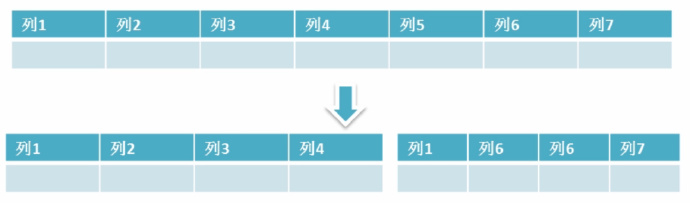

3. 大表水平分拆
举例说明：在一个论坛系统里，管理员经常会发一些帖子，这些帖子要求在每个分类列表里都要置顶。
设计方案一：在发帖表里增加一列用来标示是否是管理员发帖，这样在每个分类列表展示时就需要对发帖表查询两次，一次是置顶帖，一次是普通帖，然后将两次结果合并。如果发帖表内容较大时，查询置顶帖的性能开销会比较大。
设计方案二：将置顶帖存放在一个单独的置顶表里。因为置顶帖数量相比会很少，但访问频率很高，这样从发帖表里分拆开来，访问的性能开销会少很多。
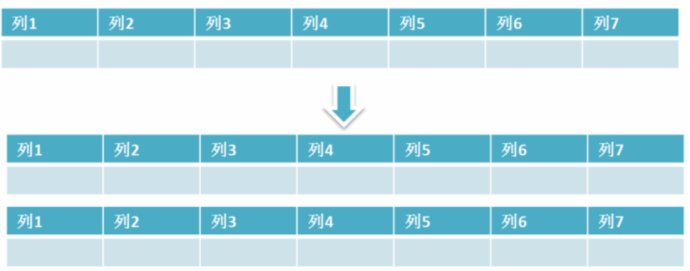

注意，这里说的大表水平拆分和平常所说的水平拆表还是有区别的。这里的大表水平分拆的得到的两个表表示的含义不一样，一个是普通贴，一个是置顶贴。平常说的水平拆表是把一个所有记录都是一致含义的表拆分。这种拆分方式最简单是通过取模的方式：比如一张有400W的用户表users，为提高其查询效率我们把其分成4张表users1，users2，users3，users4。通过用ID取模的方法把数据分散到四张表内Id%4+1 = [1,2,3,4], 然后查询,更新,删除也是通过取模的方法来查询。

4. 选择合适的数据类型

如果数据量一样，但数据类型更小的话，数据存放同样的数据就会占用更少的空间，这样检索同样的数据所带来的IO消耗自然会降低，性能也就很自然的得到提升。此外，mysql对不同类型的数据，处理方式也不一样，比如在运算或者排序操作中，越简单的数据类型操作性能越高，所以对于要频繁进行运算或者排序的字段尽量选择简单的数据类型。